* **Student**: Minhchau Dang
* **Email Address**: minhchau.dang@berkeley.edu
* **Course**: 2016-0111 DATASCI W261: Machine Learning at Scale
* **Section**: Spring 2016, Section 2
* **Assignment**: Homework 13, Week 13
* **Submission Date**: April 21, 2016

# Helper utilities

## Notebook imports

If the following cell (which imports all the Python packages used by the different drivers) doesn't run, some of the drivers and helper functions in the notebook will also fail to run. Note that you will also need `pyspark` to run the actual jobs themselves.

In [ ]:
%matplotlib inline

In [ ]:
from __future__ import division
from collections import defaultdict
from datetime import datetime
import functools
import hashlib
import matplotlib
import matplotlib.pyplot as plt
from math import exp, log
import numpy
import operator
import os
import pandas
import seaborn
import sys
import time

## Set Cluster Size

Using r3.xlarge nodes, there is 23424 MB of available memory for Yarn scheduling and there are 4 cores per server.

* http://www.ec2instances.info
* http://docs.aws.amazon.com/ElasticMapReduce/latest/ReleaseGuide/emr-hadoop-task-config.html

In [ ]:
node_count = 9
server_cores = 4
yarn_memory = 23424
executors_per_node = 1

## Set Cluster Name

In [ ]:
cluster_name = 'Week13_Criteo'

## Initialize Spark

Use the ``findspark`` library in order to help setup the Spark context. This allows the same code to work across different versions of Spark.

https://github.com/minrk/findspark

In [ ]:
import findspark
findspark.init()

import pyspark
from pyspark import SparkConf, SparkContext

Compute the configuration for our cluster.

In [ ]:
memory_per_executor = int((yarn_memory / executors_per_node) / 1.1)
cores_per_executor = int(server_cores / executors_per_node)

conf = SparkConf()
conf.setAppName(cluster_name)
conf.setMaster('yarn-client')
conf.set('spark.dynamicAllocation.enabled', False)
conf.set('spark.executor.cores', cores_per_executor)
conf.set('spark.executor.memory', str(memory_per_executor) + 'M')
conf.set('spark.executor.instances', executors_per_node * node_count)

print conf.toDebugString()

sc = SparkContext(conf=conf)

spark.app.name=Week13_Criteo
spark.driver.extraClassPath=/etc/hadoop/conf:/usr/lib/hadoop-lzo/lib/*:/usr/share/aws/aws-java-sdk/*:/usr/share/aws/emr/emrfs/conf:/usr/share/aws/emr/emrfs/lib/*:/usr/share/aws/emr/emrfs/auxlib/*
spark.driver.extraJavaOptions=-Dlog4j.configuration=file:///etc/spark/conf/log4j.properties -XX:+UseConcMarkSweepGC -XX:CMSInitiatingOccupancyFraction=70 -XX:MaxHeapFreeRatio=70 -XX:+CMSClassUnloadingEnabled -XX:MaxPermSize=512M -XX:OnOutOfMemoryError='kill -9 %p'
spark.driver.extraLibraryPath=/usr/lib/hadoop/lib/native:/usr/lib/hadoop-lzo/lib/native
spark.dynamicAllocation.enabled=False
spark.eventLog.dir=hdfs:///var/log/spark/apps
spark.eventLog.enabled=true
spark.executor.cores=4
spark.executor.extraClassPath=/etc/hadoop/conf:/usr/lib/hadoop-lzo/lib/*:/usr/share/aws/aws-java-sdk/*:/usr/share/aws/emr/emrfs/conf:/usr/share/aws/emr/emrfs/lib/*:/usr/share/aws/emr/emrfs/auxlib/*
spark.executor.extraJavaOptions=-verbose:gc -XX:+PrintGCDetails -XX:+PrintGCDateStamps -X

# HW 13.4: Criteo Phase 2 baseline

> The Criteo data for this challenge is located in the following S3/Dropbox buckets:

> On Dropbox see:
> * https://www.dropbox.com/sh/dnevke9vsk6yj3p/AABoP-Kv2SRxuK8j3TtJsSv5a?dl=0

> Raw Data:  (Training, Validation and Test data)
> * https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=rawdata/

> Hashed Data: Training, Validation and Test data in hash encoded (10,000 buckets) and sparse representation
> * https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=processeddata/

First, we need functions that can load our data files into `LabeledPoint` objects used in logistic regression.

In [ ]:
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint

# Compute the hash using the same code as the CTR assignment

def hashFunction(numBuckets, rawFeats):
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)

    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

# Convert a tab-separated string into a LabeledPoint

def hashPoint(numBuckets, data):
    label = float(point.split('\t')[0])

    featureValues = point.split('\t')[1:]
    featureCount = len(featureValues)
    features = [(featureId, x) for featureId, x in zip(numpy.arange(featureCount), featureValues)]

    return LabeledPoint(label, SparseVector(numBuckets, hashFunction(numBuckets, features)))

# Deserialize a LabeledPoint that was serialized as a tuple

def moduloPoint(numBuckets, data):
    label, sparse = eval(data)
    numBuckets, indices, values = sparse

    features = {}

    for index, value in zip(indices, values):
        modIndex = index % numBuckets

        if modIndex in features:
            features[modIndex] += value
        else:
            features[modIndex] = value

    return LabeledPoint(label, SparseVector(numBuckets, features))

# Load the data as a materialized RDD

cachedDataSets = {}

def getParsedData(numBuckets, subfolders):
    global cachedDataSets

    if 10000 % numBuckets == 0:
        print 'Computing modulo of processed data'
        folder = 'processeddata'
        parseFunction = functools.partial(moduloPoint, numBuckets)
    else:
        print 'Computing hash of raw data'
        folder = 'rawdata'
        parseFunction = functools.partial(hashPoint, numBuckets)

    # Build the RDDs from the S3 URLs for train, validation, test

    dataRDDs = []

    for subfolder in subfolders:
        now = datetime.today()
        print now, 'Materializing text file RDD for', subfolder

        dataPath = 's3://criteo-dataset/%s/%s' % (folder, subfolder)

        if dataPath in cachedDataSets:
            folderRDD = cachedDataSets[dataPath]
        else:
            folderRDD = sc.textFile(dataPath).cache()
            folderRDD.count()

            cachedDataSets[dataPath] = folderRDD

        now = datetime.today()
        print now, 'Materializing parsed RDD for', subfolder

        dataRDD = folderRDD.map(parseFunction).cache()
        dataRDD.count()

        dataRDDs.append(dataRDD)

    return dataRDDs

Now we load the 1000 bucket data set.

In [ ]:
%time hashedRawTrainRDD, hashedRawValidationRDD, hashedRawTestRDD = \
    getParsedData(1000, ['train', 'validation', 'test'])

Computing modulo of processed data
2016-04-26 20:49:08.009124 Materializing text file RDD for train
2016-04-26 20:49:53.909622 Materializing parsed RDD for train
2016-04-26 20:57:44.647520 Materializing text file RDD for validation
2016-04-26 20:57:52.553115 Materializing parsed RDD for validation
2016-04-26 20:58:53.391626 Materializing text file RDD for test
2016-04-26 20:59:00.767335 Materializing parsed RDD for test
CPU times: user 196 ms, sys: 56 ms, total: 252 ms
Wall time: 10min 53s


## Train the Logistic Regression

> Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiment:

> Write spark code (borrow from Phase 1 of this project) to train a logistic regression model with the following hyperparameters:

> * Number of buckets for hashing: 1,000
> * Logistic Regression: no regularization term
> * Logistic Regression: step size = 10

Now we perform the linear regression (100 iterations) on the materialized and cached RDD and record the elapsed time for reporting purposes.

In [ ]:
from pyspark.mllib.classification import LogisticRegressionWithSGD

numIters = 100
stepSize = 10.0
regParam = 1e-6
regType = 'none'
includeIntercept = True

%time model = LogisticRegressionWithSGD.train( \
    data=hashedRawTrainRDD, iterations=numIters, step=stepSize, \
    regParam=regParam, regType=regType, intercept=includeIntercept)

CPU times: user 2.38 s, sys: 652 ms, total: 3.03 s
Wall time: 2min 27s


> Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

* **Instance Type**: [Memory Optimized](https://aws.amazon.com/ec2/instance-types/#memory-optimized)
* **Instance Class**: r3.xlarge
* **Cluster Size**: 1 master, 9 core
* **Job Completion Time**: 1 minute, 48 seconds

## Evaluate Logistic Regression

> Report in tabular form the AUC value (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.

First, we need to compute those metrics.

In [ ]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

modelBroadcast = sc.broadcast(model)

# Compute the prediction

def getBoundedPrediction(features):
    rawPrediction = features.dot(modelBroadcast.value.weights) + modelBroadcast.value.intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)

    return 1.0 / (1.0 + exp(-rawPrediction))

# Compute the scores and labels

def getScoresAndLabels(point):
    return getBoundedPrediction(point.features), point.label

# Compute the area under the ROC curve

def getAreaUnderROC(dataRDD):
    scoresAndLabelsRDD = dataRDD.map(getScoresAndLabels)
    metrics = BinaryClassificationMetrics(scoresAndLabelsRDD)
    return metrics.areaUnderROC

# Run code against all data sets

hashedRawTrainAUC = getAreaUnderROC(hashedRawTrainRDD)
hashedRawValidationAUC = getAreaUnderROC(hashedRawValidationRDD)
hashedRawTestAUC = getAreaUnderROC(hashedRawTestRDD)

Next, we'll put it into a nice table.

In [ ]:
pandas.DataFrame(data=[
    ('Train', hashedRawTrainAUC),
    ('Validation', hashedRawValidationAUC),
    ('Test', hashedRawTestAUC)
])

,0,1
0,Train,0.737904
1,Validation,0.737722
2,Test,0.737983


> Report in tabular form  the logLossTest for the Training, Validation, and Testing datasets.

First, we need to compute this metric.

In [ ]:
# Compute an individual log loss using the same code as the CTR assignment

def computeLogLoss(scoreAndLabel):
    prediction, label = scoreAndLabel

    epsilon = 10e-12

    if label == 1.0:
        if prediction == 0.0:
            return -log(epsilon)
        if prediction == 1.0:
            return -log(1.0-epsilon)
        return -log(prediction)

    if label == 0.0:
        if prediction == 0.0:
            return -log(1.0-epsilon)
        if prediction == 1.0:
            return -log(epsilon)

        return -log(1.0-prediction)

# Compute the average log loss using the same code as the CTR assignment

def getAverageLogLoss(dataRDD):
    scoresAndLabelsRDD = dataRDD.map(getScoresAndLabels)
    logLossRDD = scoresAndLabelsRDD.map(computeLogLoss)
    return logLossRDD.mean()

# Run code against all data sets

hashedRawTrainLogLoss = getAverageLogLoss(hashedRawTrainRDD)
hashedRawValidationLogLoss = getAverageLogLoss(hashedRawValidationRDD)
hashedRawTestLogLoss = getAverageLogLoss(hashedRawTestRDD)

Next, we'll put it into a nice table.

In [ ]:
pandas.DataFrame(data=[
    ('Train', hashedRawTrainLogLoss),
    ('Validation', hashedRawValidationLogLoss),
    ('Test', hashedRawTestLogLoss)
])

,0,1
0,Train,0.497478
1,Validation,0.497643
2,Test,0.497676


# HW 13.5: Criteo Phase 2 hyperparameter tuning

## Unpersist old RDDs

We can run out of memory quickly on our Spark cluster if we persist all of the RDDs we've computed so far. While we cache the data loading, we'll uncache the parsed data.

In [ ]:
hashedRawTrainRDD.unpersist()
hashedRawValidationRDD.unpersist()
hashedRawTestRDD.unpersist()

PythonRDD[23] at RDD at PythonRDD.scala:43

## Train the Logistic Regression

> Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiments:

> Write spark code (borrow from Phase 1 of this project) to train a logistic regression model with various hyperparameters. Do a gridsearch of the hyperparameter space and determine optimal settings using the validation set.

> * Number of buckets for hashing: 1,000, 10,000, .... explore different values  here
> * Logistic Regression: regularization term: [1e-6, 1e-3]  explore other  values here also
> * Logistic Regression: step size: explore different step sizes. Focus on a stepsize of 1 initially

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder

bucketSizes = [100, 1000, 10000]

# Provide a function which computes the log loss on the validation set
# after training the model on the training set.

def getModelMetrics(trainRDD, validationRDD, parameters):
    global modelBroadcast

    now = datetime.today()
    print now, parameters

    model = LogisticRegressionWithSGD.train(data=trainRDD, iterations=numIters, **parameters)
    modelBroadcast = sc.broadcast(model)

    return getAreaUnderROC(validationRDD), getAverageLogLoss(validationRDD)

start = time.time()

# Build up the parameter grid

builder = ParamGridBuilder()
builder.addGrid('step', [1])
builder.addGrid('regParam', [1e-6, 1e-5, 1e-4, 1e-3, 1e-2])
builder.addGrid('regType', ['none', 'l1', 'l2'])
builder.addGrid('intercept', [True])

# Save the best parameters and the best log loss encountered

bestParameters = {}
bestLogLoss = sys.maxint

# Iterate over all desired bucket sizes and parameter combinations and
# compute the metrics. Build up a list of all the results for later steps.

modelMetrics = []

for bucketSize in bucketSizes:
    trainRDD, validationRDD = getParsedData(bucketSize, ['train', 'validation'])

    for parameters in builder.build():
        areaUnderROC, logLoss = getModelMetrics(trainRDD, validationRDD, parameters)
        parameters['bucketSize'] = bucketSize
        parameters['areaUnderROC'] = areaUnderROC
        parameters['logLoss'] = logLoss

        modelMetrics.append(parameters)

    trainRDD.unpersist()
    validationRDD.unpersist()

end = time.time()

Computing modulo of processed data
2016-04-26 21:17:10.250724 Materializing text file RDD for train
2016-04-26 21:17:10.250873 Materializing parsed RDD for train
2016-04-26 21:25:01.334235 Materializing text file RDD for validation
2016-04-26 21:25:01.334460 Materializing parsed RDD for validation
2016-04-26 21:26:01.919063 {'regParam': 1e-06, 'step': 1, 'intercept': True, 'regType': 'none'}
2016-04-26 21:28:54.904692 {'regParam': 1e-06, 'step': 1, 'intercept': True, 'regType': 'l1'}
2016-04-26 21:32:10.657762 {'regParam': 1e-06, 'step': 1, 'intercept': True, 'regType': 'l2'}
2016-04-26 21:35:07.979296 {'regParam': 1e-05, 'step': 1, 'intercept': True, 'regType': 'none'}
2016-04-26 21:38:05.127164 {'regParam': 1e-05, 'step': 1, 'intercept': True, 'regType': 'l1'}
2016-04-26 21:41:02.624933 {'regParam': 1e-05, 'step': 1, 'intercept': True, 'regType': 'l2'}
2016-04-26 21:43:57.140942 {'regParam': 0.0001, 'step': 1, 'intercept': True, 'regType': 'none'}
2016-04-26 21:46:53.039869 {'regPara

> Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

The times will be high due to the materialization of the RDDs in the middle of the iterations (required because of the high amount of memory in the sparse vector representation of the encoded features).

In [ ]:
print 'Wall time:', str(int((end - start) / 60)) + 'min', str(int(end - start) % 60) + 's'

Wall time: 159min 37s


* **Instance Type**: [Memory Optimized](https://aws.amazon.com/ec2/instance-types/#memory-optimized)
* **Instance Class**: r3.xlarge
* **Cluster Size**: 1 master, 9 core
* **Job Completion Time**: 159 minutes, 37 seconds

## Evaluate the Logistic Regression

> Report in tabular form and using heatmaps the AUC values (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.
Report in tabular form and using heatmaps  the logLossTest for the Training, Validation, and Testing datasets.

> Don't forget to put a caption on your tables (above the table) and on your heatmap figures (put caption below figures) detailing the experiment associated with each table or figure (data, algorithm used, parameters and settings explored.

First, we print out the raw dictionary so that we can perform the analysis without having to wait for the whole thing to complete again.

In [ ]:
df = pandas.DataFrame(modelMetrics)
df

,areaUnderROC,bucketSize,intercept,logLoss,regParam,regType,step
0,0.700719,100,True,0.521904,0.000001,none,1
1,0.700700,100,True,0.521914,0.000001,l1,1
2,0.700719,100,True,0.521904,0.000001,l2,1
3,0.700719,100,True,0.521904,0.000010,none,1
4,0.700522,100,True,0.521999,0.000010,l1,1
5,0.700718,100,True,0.521906,0.000010,l2,1
6,0.700719,100,True,0.521904,0.000100,none,1
7,0.698864,100,True,0.522801,0.000100,l1,1
8,0.700713,100,True,0.521918,0.000100,l2,1
9,0.700719,100,True,0.521904,0.001000,none,1


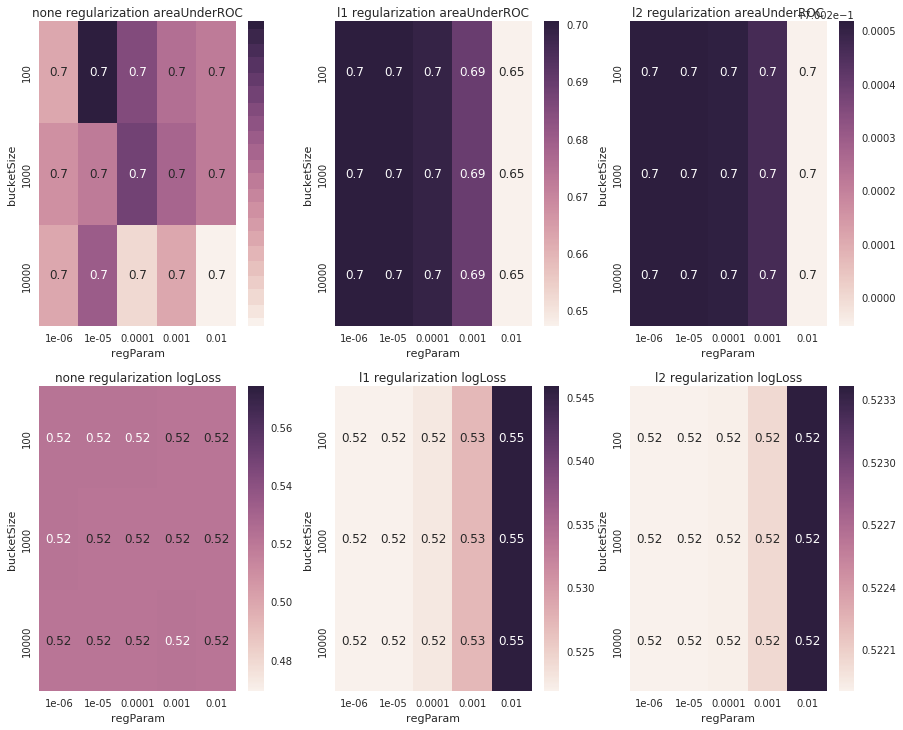

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 12))

for i, regType in zip(range(3), ['none', 'l1', 'l2']):
    for j, measure in zip(range(2), ['areaUnderROC', 'logLoss']):
        pivot_df = df[df['regType'] == regType].pivot('bucketSize', 'regParam', measure)
        seaborn.heatmap(pivot_df, ax=axes[j, i], annot=True)
        axes[j, i].set_title(regType + ' regularization ' + measure)

## Reflect on the Evaluation of the Logistic Regression

> Discuss the optimal setting to solve this problem  in terms of the following:
> * Features
> * Learning algorithm
> * Spark cluster

> Justify your recommendations based on your experimental results and cross reference with table numbers and figure numbers. Also highlight key results with annotations, both textual and line and box based, on your tables and graphs.

### Features

As we can see in the heat map, increasing the number of buckets slightly improves the average log loss while increasing the complexity of the model, but it is not significant -- it shifts from approximately 0.52 for large numbers of buckets to 0.54 for smaller buckets.

There is a noticeable increase between 100 and 1000 in terms of area under the ROC curve (from 0.66 to 0.70) and an only barely noticeable increase between 1000 and 1000 (when rounded, both values are at 0.70). This means that ideally, we'd choose 1000 in order to balance complexity with generizability.

### Learning Algorithm

When looking at the regularization parameter type, we notice that L2 regularization is slightly better than L1 regularization in terms of consistency across regularization parameter values. This means we can have a larger regularization parameter if we choose L2 regularization. Efficiency appears to cap at around 0.001 with only a slight improvement for smaller regularization parameters.

### Spark Cluster

One of the problems in this assignment was making sure we had sufficient memory to hold the training and validation data sets and so you would need to frequently unpersist the values in order to allow for the next iteration of grid search. This makes it more difficult to re-test values within the grid search without having to re-parse the data set.